![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/NATURAL_SCENE.ipynb)

# Recognize text in natural scenes

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Read licence key

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Install Dependencies

In [3]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

     |████████████████████████████████| 133 kB 4.9 MB/s 
     |████████████████████████████████| 198 kB 64.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/3.9.1-687fb5e0a5c810221f8467e53c1e7f9380b8080a
     |████████████████████████████████| 20.7 MB 26.5 MB/s 
     |████████████████████████████████| 29.2 MB 1.9 MB/s 
     |████████████████████████████████| 2.2 MB 39.2 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 whi

Importing Libraries

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources


Start Spark Session

In [3]:
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



## 2. Load image

In [10]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/natural_scene.jpeg')
image_df = spark.read.format("binaryFile").load(imagePath).cache()
image_df.show()


+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/usr/local/l...|2022-01-10 17:15:...|133271|[FF D8 FF DB 00 8...|
+--------------------+--------------------+------+--------------------+



## 3. Construct the OCR pipeline

In [11]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(71)
binarizer.setOffset(65)

remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("binarized_image")
remove_objects.setOutputCol("cleared_image")
remove_objects.setMinSizeObject(400)
remove_objects.setMaxSizeObject(4000)

# Apply morphology opening
morpholy_operation = ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(5)
morpholy_operation.setOperation("closing")
morpholy_operation.setInputCol("cleared_image")
morpholy_operation.setOutputCol("corrected_image")

# Run OCR
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

## 4. Run OCR pipeline

In [12]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [13]:
result.select("text", "confidence").show()

+----+------------------+
|text|        confidence|
+----+------------------+
|    |39.155494689941406|
+----+------------------+



Display text and images


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 640 px
    Height: 480 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


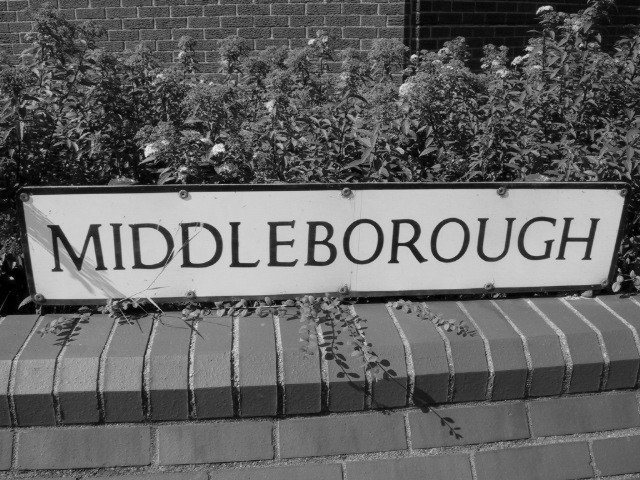


 Text:  


In [8]:
for r in result.distinct().collect():
  display_image(r.image)
  print ('\n', 'Text: ',r.text)

Showing and saving intermediate processing results as jpg

Original: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg

    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 640 px
    Height: 480 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


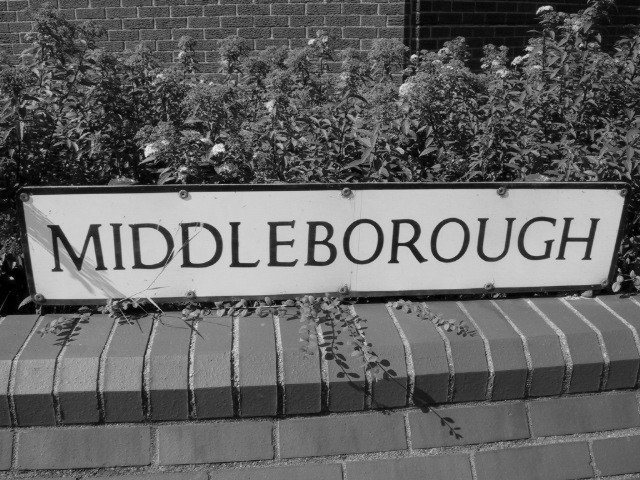

Binarized

    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 1280 px
    Height: 960 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


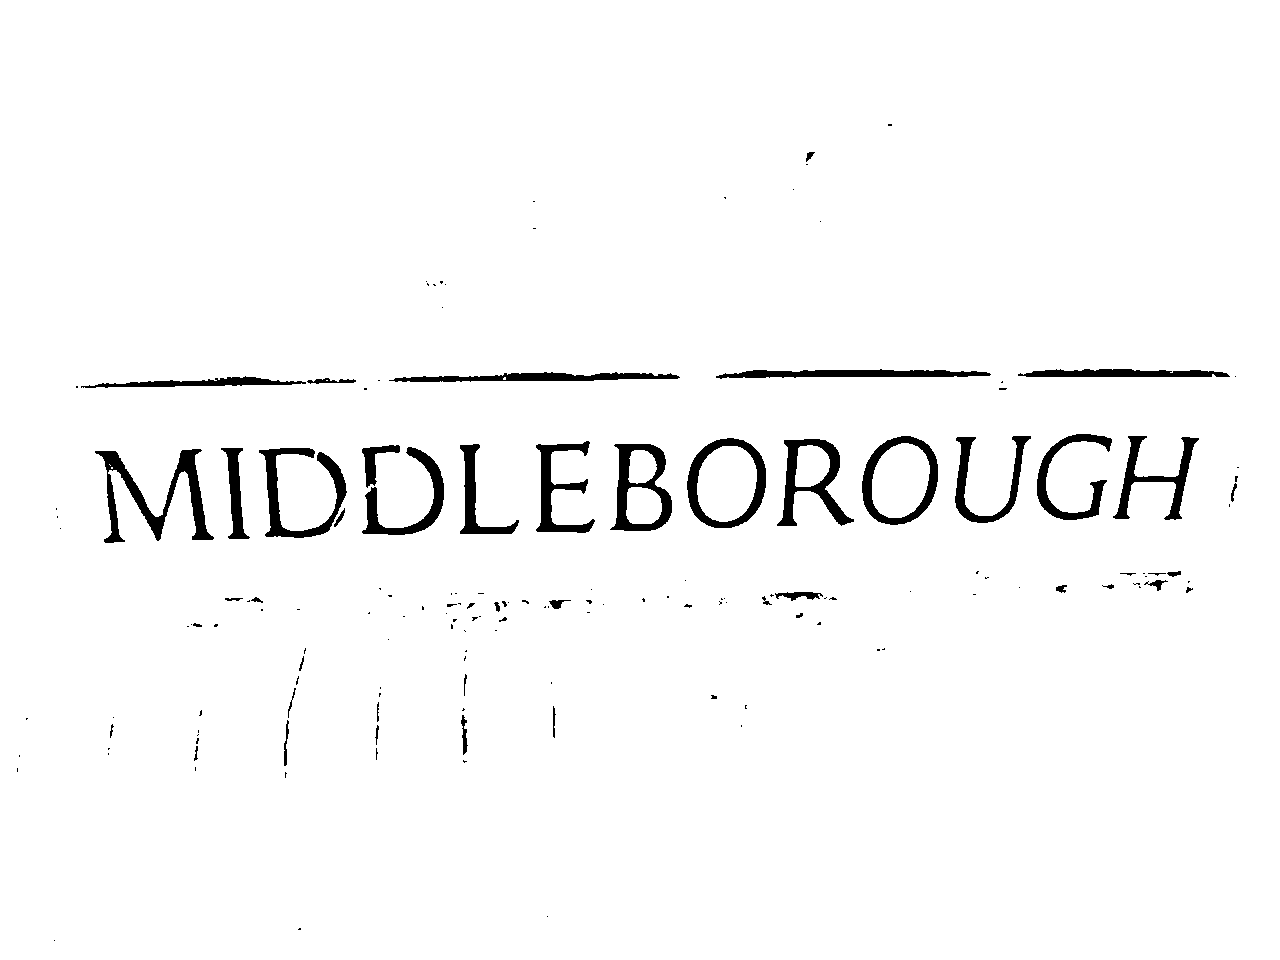

Removing objetcts

    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 1280 px
    Height: 960 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


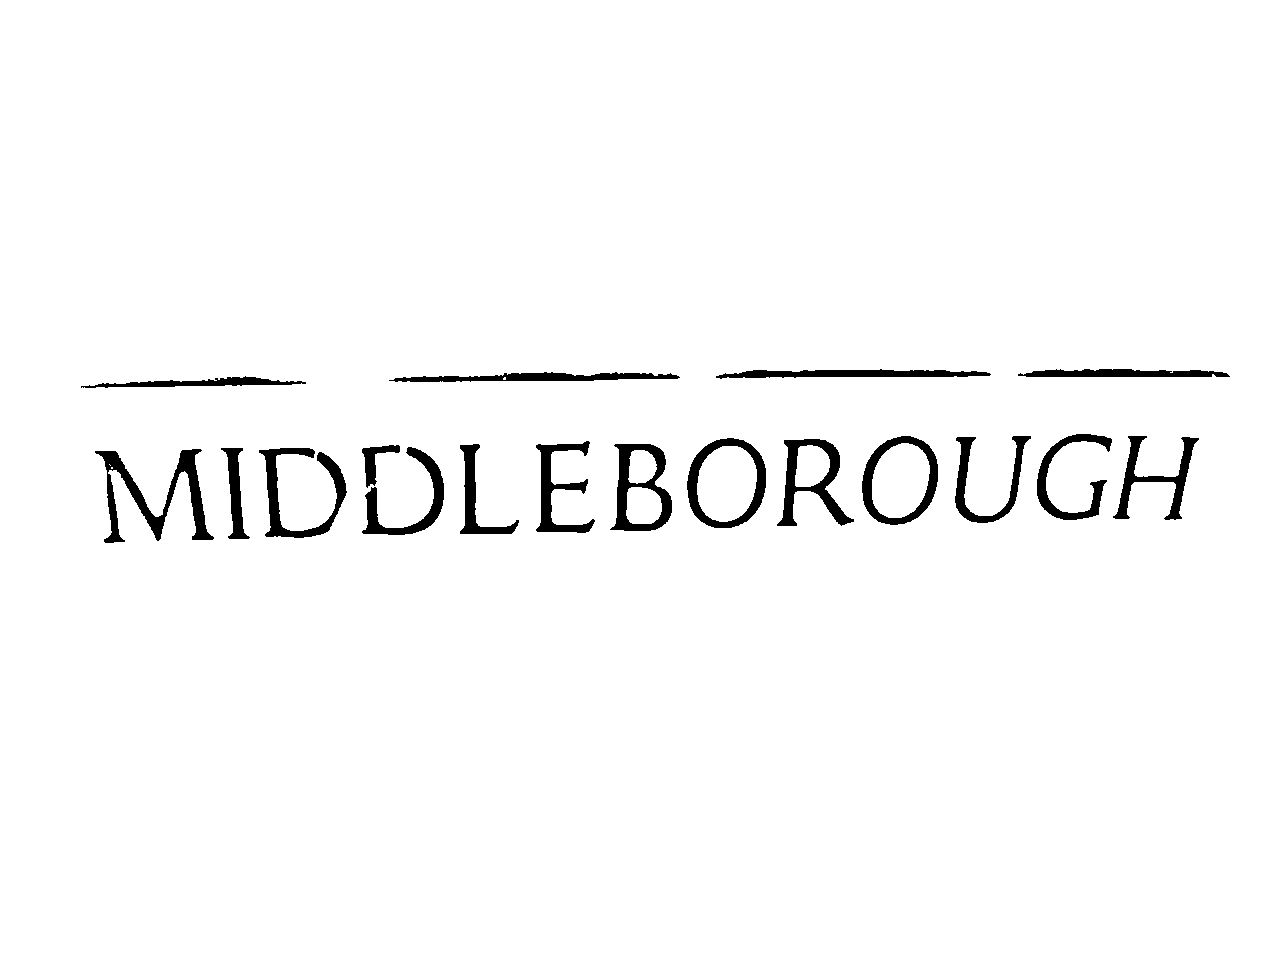

Morphology closing

    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 1280 px
    Height: 960 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


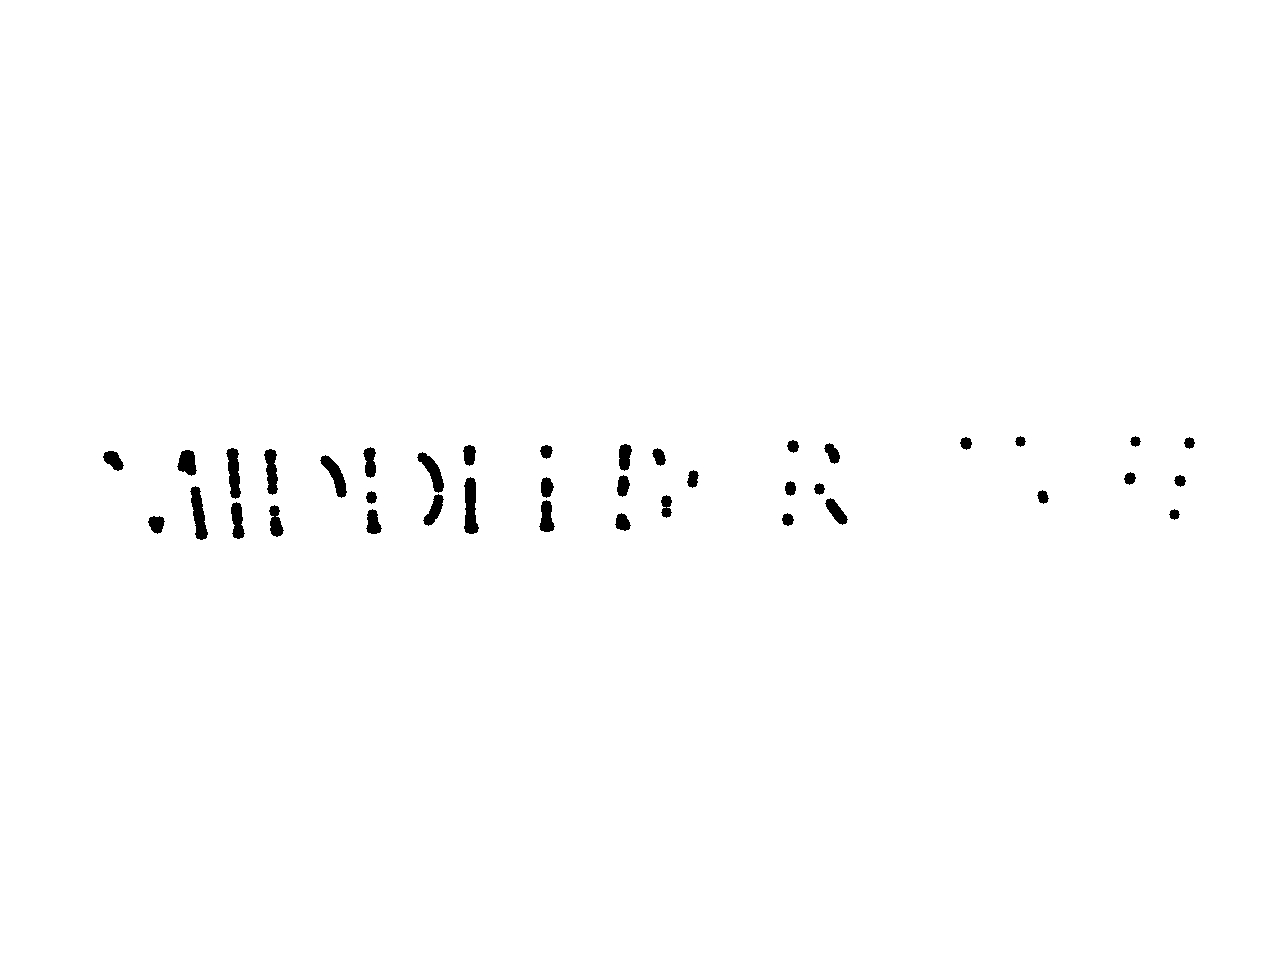

In [9]:
for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized")
    display_image(r.binarized_image)
    print("Removing objetcts")
    display_image(r.cleared_image)
    print("Morphology closing")
    display_image(r.corrected_image)

    img = to_pil_image(r.binarized_image, r.binarized_image.mode)
    img.save('img_binarized.jpg')